# Data Analysis of Historical Major League Baseball Data
**Udacity - Data Analysis Nanodegree**: Mitchell Barnes-Wallace
## Introduction
Like most businesses, the game of baseball is about maximizing investment yields and producing a winning product. For baseball, investments come in the form of player salaries, yields in the form of team wins and player production and a winning product equates to making the playoffs and winning the World Series. There are several ways to calculate a player's worth to a team, Wins Above Replacement or WAR is the most common metric for analyzing a player’s value to a ball club. This statistic is calculated by computing a player’s value above (or below) a replacement level baseball player, for both batters and pitchers. I will be looking at Fielding Independent Pitching (FIP), which is one factor put into the calculation of a Pitcher’s WAR. Using only data from 1985-2015 (since 1985 is the first year of salary data), I want to investigate how well FIP correlates with other statistics. FIP was created to improve the evaluation of pitchers, so first I will compare ERA to FIP and see how well ERA correlates to FIP. To make sure that teams are getting value out of their investments, I will look at FIP as it relates to salary on both an individual and team level. For starting pitchers, I want to find out what impact FIP has on Wins, and on the team level I want to see what impact FIP has on the number of team wins. I expect to see a lower FIP resulting in more wins and higher salaries. For additional analysis I will look at FIP on the individual level for All Stars and Non All Stars and on the team level between Division Winners and Non Division Winners (taking the top 5 teams in each league, as that is the requirement for making the playoffs currently)

In [4]:
#Import the nessecary classes for this analysis
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from IPython.display import Math
import matplotlib
import matplotlib.pyplot as plt
import locale #allow for printing in money
locale.setlocale( locale.LC_ALL, '' )

'en_US.UTF-8'

In [5]:
%matplotlib inline  

In [6]:
#Function to read in all of the csv
def import_csv(csv):
    #file path to the csv, change if CSVs are elsewhere
    folder_location = '/Users/mitchellbarnes-wallace/Downloads/baseballdatabank-master/core/' 
    csv_location = folder_location+csv #create csv location to read
    table = pd.DataFrame(pd.read_csv(csv_location))
    if 'yearID' in table.columns:
        table = table[table.yearID >= 1985] # removing all data before 1985
    table = table.fillna(value = 0) # replacing all NAN values with 0,baseball data this should be fine, except death information in the master list
    return table

First step is in initialize the data tables that I will need in order to calculate FIP and Salary. Looking at the master table, pitching, salaries and the teams csv, I should have all of the information nessecary in order to perform this analysis. 

In [7]:
#load the csv_files into panda dataframes
apperance_table = import_csv('Appearances.csv')
master = import_csv('Master.csv')
pitching_table = import_csv('Pitching.csv')
salaries_table = import_csv('Salaries.csv')
teams_table = import_csv('Teams.csv')
all_star_table = import_csv('AllstarFull.csv')
awards = import_csv('AwardsPlayers.csv')

In [8]:
#optional display of teams
"""
display(teams_table[['yearID','teamID','Rank']].head(50))
display(teams_table[['teamID', 'Rank']].head())
display(master.head())
display(apperance_table.head())
display(pitching_table.head())
display(salaries_table.head())
display(all_star_table.head())
display(all_star_table.head())
display(awards.head())"""

"\ndisplay(teams_table[['yearID','teamID','Rank']].head(50))\ndisplay(teams_table[['teamID', 'Rank']].head())\ndisplay(master.head())\ndisplay(apperance_table.head())\ndisplay(pitching_table.head())\ndisplay(salaries_table.head())\ndisplay(all_star_table.head())\ndisplay(all_star_table.head())\ndisplay(awards.head())"

## Calculating FIP
The formula for calculating FIP is decently long but I have listed it out here with a link to the Fangraphs formula [here](http://www.fangraphs.com/library/pitching/fip/). 

**FIP** = $\frac{13 \times HR + 3\times (BB +\ HBP) - 2 \times K}{IP} +\ FIP_C$

**FIP Constant** = $FIP_C = lgERA -\ \frac{13 \times lgHR + 3\times (lgBB +\ lgHBP) - 2*lgK}{lgIP}$

HR: Homerun allowed

BB: Base on balls

HBP: Hit by pitch

K: Strikeout

IP: Inning Pitch

lgERA: League Earned Run Average (9*Earned runs/IP)

lg in front of any stat is the cummulative league stat

**Defining A Starting Pitcher**
Qualify for ERA and FIP leaderboards, a pitcher needs to pitching a minimum of 1 IP per team game. Looking only at qualifying pitchers will provide a large sample for each player in a given season, while giving each player similar opportunities to "win" a game. 

## Functions and Code for Data Wrangling and Calculations

In [9]:
def era(dataframe):
    #calculate Earned Run Average
    era = (dataframe['ER']*9)/(dataframe['IPouts']/3)
    return era

In [10]:
def fip_calculation(dataframe):
    #calculate fielding independent pitching fraction term
    output = ((13*dataframe['HR'])+3*(dataframe['BB']+dataframe['HBP'])\
                                                          -2*dataframe['SO'])/(dataframe['IPouts']/3)
    return output

Function to calculate the mean and standard deviation by year for any column in a Dataframe

In [11]:
def standard_mean(dataframe,column):
    #calculate the standard deviation for each year
    standard = dataframe.std(level = 0)
    standard = standard.reindex(dataframe.index, level=0)
    #calculate the mean for each year
    mean = dataframe.mean(level = 0)
    mean = mean.reindex(dataframe.index, level=0)
    return standard,mean

In [12]:
#Calculating total data for each MLB Season 
pitchingGroupedYearlyTotal = pitching_table.groupby(by=['yearID']).sum().reset_index() #combine all pitching statistics for each season
pitchingGroupedYearlyTotal['yearly_fip'] = era(pitchingGroupedYearlyTotal) - fip_calculation(pitchingGroupedYearlyTotal)

yearlyFIPconstant = pitchingGroupedYearlyTotal[['yearID','yearly_fip']].set_index(['yearID'])
team_Games = teams_table[['yearID','teamID','G']].reset_index()
#setting the index for the teams_table to be used later
teams_table_indexed = teams_table.set_index(['yearID','teamID'])

#### Inputting the relevant awards data into the player's table. 

In [13]:
#Modify Awards table to include these features in the main player dataframe
cy_young = awards[awards.awardID == "Cy Young Award"].set_index(['playerID','yearID'])
mvp = awards[awards.awardID == "Most Valuable Player"].set_index(['playerID','yearID'])
allstar = all_star_table.set_index(['yearID','playerID'])
allstar['All_Star'] = 'All Star'
mvp = mvp.replace(to_replace = "Most Valuable Player",value = True)
cy_young = cy_young.replace(to_replace = "Cy Young Award",value = True)

In [14]:
#combining all salary data for every player and for every team by year
individual_salary = salaries_table.groupby(by=['playerID','yearID']).sum().reset_index()

### Calculating Individual Data

In [15]:
#pitching table grouped by player and year
pitching_grouped_indv = pitching_table.groupby(by = ['yearID','playerID','teamID']).sum().reset_index()
pitching_grouped_indv = pitching_grouped_indv.set_index('yearID')
#calculation of individual pitchers FIP stat
pitching_grouped_indv['fip_fact'] = fip_calculation(pitching_grouped_indv)
# input yearly FIP constant into player table
pitching_grouped_indv['FIP'] = pitching_grouped_indv['fip_fact'] + yearlyFIPconstant['yearly_fip']
#add all games played by players team in that season
pitching_grouped_indv = pitching_grouped_indv.reset_index().merge(team_Games, on = ['yearID','teamID'],how = 'inner').merge(individual_salary,on = ['yearID','playerID'],how = 'inner')
#all pitchers kept in this dataframe for later manipulation
pitching_grouped_indv_total = pitching_grouped_indv[['yearID','teamID','salary']]
# remove all players that didn't qualify, aka pitch more than 1 IP per team game
pitching_grouped_indv = pitching_grouped_indv[pitching_grouped_indv.IPouts >= 3*pitching_grouped_indv.G_y]
#calculate individual ERA
pitching_grouped_indv['ERA'] = pitching_grouped_indv['ER']*27/pitching_grouped_indv['IPouts']
#set the index to playerID and yearID to match up with cy_young,mvp and allstar data frames
pitching_grouped_indv = pitching_grouped_indv.set_index(['yearID','playerID'])
# reset index, then set to yearID, playerID and teamID to calculate the remaining information
# pitching_grouped_indv.reset_index().set_index(['yearID','playerID','teamID'])
#calculate the salary z score by year
standard_player, mean_player = standard_mean(pitching_grouped_indv,'salary')
pitching_grouped_indv['salary_Z'] = (pitching_grouped_indv['salary']-mean_player['salary'])/standard_player['salary']
pitching_grouped_indv['cy_young'] = cy_young['awardID']
pitching_grouped_indv['mvp'] = mvp['awardID']
pitching_grouped_indv['all_star'] = allstar['All_Star']
pitching_grouped_indv.ix[pitching_grouped_indv.all_star != 'All Star', 'all_star'] = 'Non All Star'
pitching_grouped_indv[['cy_young','mvp']] = pitching_grouped_indv[['cy_young','mvp']].fillna(value = False)
#reduce the size of the dataframe being passed to graph
player_FIP_graph_data = pitching_grouped_indv[['FIP','W','ERA','salary_Z','all_star','cy_young','mvp']]

### Calculating Team Data

In [16]:
#Calculate team salary on for pitchers
team_salary = pitching_grouped_indv_total.reset_index()
team_salary = team_salary.groupby(by=['teamID','yearID']).sum().reset_index()
team_salary = team_salary[['teamID','yearID','salary']]
#team fip numbers calculated
pitching_grouped_team = pitching_table.groupby(by=['yearID','teamID']).sum().reset_index()
pitching_grouped_team = pitching_grouped_team.set_index('yearID')
pitching_grouped_team['fip_fact'] = fip_calculation(pitching_grouped_team)
#calculate the overall fip score for each team
pitching_grouped_team['FIP'] = pitching_grouped_team['fip_fact'] + yearlyFIPconstant['yearly_fip']
pitching_grouped_team['ERA'] = pitching_grouped_team['ER']*27/pitching_grouped_team['IPouts']
#add team salary to dataframe
pitching_grouped_team = pitching_grouped_team.reset_index().merge(team_salary,on = ['teamID','yearID'],how = 'inner').\
                set_index(['yearID','teamID'])
pitching_grouped_team['Rank'] = teams_table_indexed['Rank']
#create the z score for the salary by year
standard_team, mean_team = standard_mean(pitching_grouped_team,'salary')
pitching_grouped_team['salary_Z'] = (pitching_grouped_team['salary']-mean_team['salary'])/standard_team['salary']
#input team data with whether or not the team made the playoffs
pitching_grouped_team['playoff'] = 'Non Division Winner'
pitching_grouped_team.ix[pitching_grouped_team.Rank <= 1, 'playoff'] = 'Division Winner'
team_FIP_graph_data = pitching_grouped_team[['W','salary','FIP','salary_Z','ERA','playoff']]

### Calculating Salary
As displayed in the cell below, the average salary for both teams and players increased quite substantially in this 30 year range, increase of over \$57 million for teams and \$6 million for players. I therefore thought it would be useful to convert the salary data to a Z score by year. This puts the salary data on a similar scale. For team salary I only took into account the salary of qualifying starters. 

In [17]:
meanTeamSalary = pitching_grouped_team['salary'].mean(level = 0)
meanPlayerSalary = pitching_grouped_indv['salary'].mean(level = 1)
salaryDiffTeam = meanTeamSalary.max() - meanTeamSalary.min()
salaryDiffPlayer = meanPlayerSalary.max() - meanPlayerSalary.min()
print 'Increase in average team salary: ',locale.currency(salaryDiffTeam,grouping = True)\
        ,"\nIncrease in average qualifying pitcher's salary:", locale.currency(salaryDiffPlayer,grouping = True)

Increase in average team salary:  $57,246,849.00 
Increase in average qualifying pitcher's salary: $13,241,071.00


In [18]:
""" #optional graphs for analyzing all_stars and cy_young award winners
sns.lmplot(x="FIP",y="W",data=player_FIP_graph_data , hue='all_star',fit_reg=False)
sns.lmplot(x="FIP",y="salary_Z",data=player_FIP_graph_data , hue='cy_young',fit_reg=False)
sns.lmplot(x="FIP",y="ERA",data=player_FIP_graph_data , hue='cy_young',fit_reg=False);"""

' #optional graphs for analyzing all_stars and cy_young award winners\nsns.lmplot(x="FIP",y="W",data=player_FIP_graph_data , hue=\'all_star\',fit_reg=False)\nsns.lmplot(x="FIP",y="salary_Z",data=player_FIP_graph_data , hue=\'cy_young\',fit_reg=False)\nsns.lmplot(x="FIP",y="ERA",data=player_FIP_graph_data , hue=\'cy_young\',fit_reg=False);'

## Data Visualization Using Seaborn

### Qualifying Pitcher's ERA vs FIP

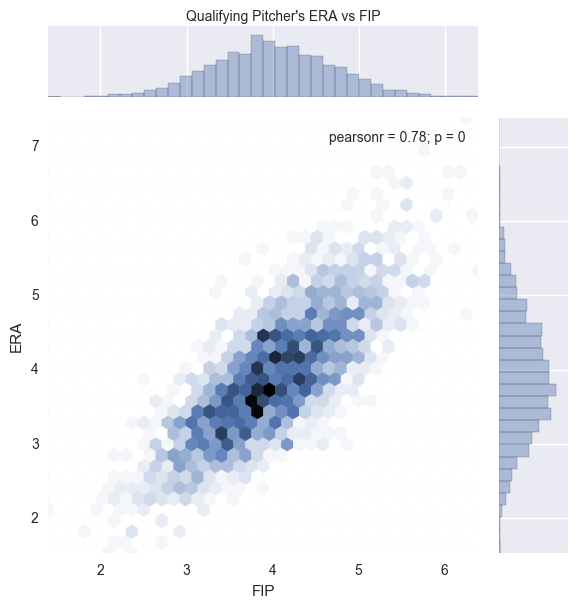

In [19]:
## Qualifying Pitcher's ERA related to FIP
sns.jointplot(x="FIP", y="ERA",kind ="hex", data=player_FIP_graph_data,space = 0.3).\
            set_axis_labels('FIP','ERA')
plt.suptitle("Qualifying Pitcher's ERA vs FIP",verticalalignment = 'bottom')

In this graph, we see Earned Run Average (ERA) plotted against Fielding Independent Pitching (FIP). As indicated from the Pearson's R listed on the graph, 0.78 there is a strong correlation between these two values. As the FIP generally increases, so to does ERA. It is also worth noting that both ERA and FIP are distributed approximentally normally. The strong correlation here between ERA and FIP makes sense, as both values are used to determine a pitcher's value. One value must more accurately determines a player's value. 

### Qualifying Pitcher's Wins vs FIP

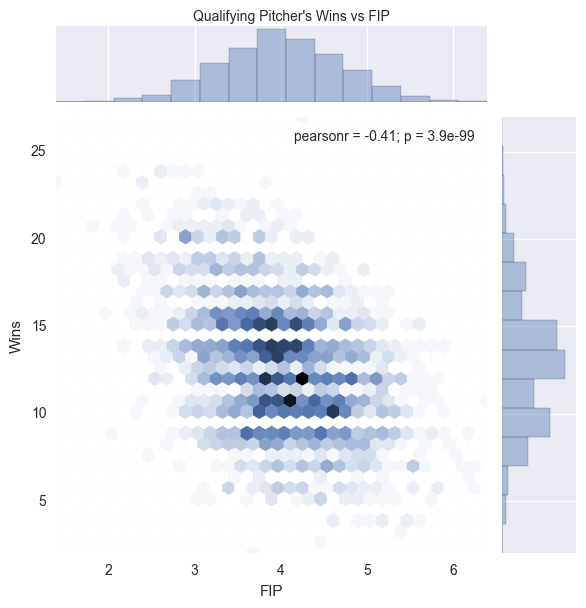

In [20]:
#Qualifying Pitchers Wins as it compares to FIP
sns.jointplot(x="FIP", y="W",kind = 'hex', data=player_FIP_graph_data,marginal_kws=dict(bins=15)).set_axis_labels('FIP','Wins')
plt.suptitle("Qualifying Pitcher's Wins vs FIP",verticalalignment = 'bottom')

In this graph qualifying pitcher's Wins are plotted against their FIP. Here we see a -0.41 Pearson's R value, which indicates that the lower a pitcher's FIP the more games they are likely to win. Wins are distributed relatively normally here as well. Here we see that a good FIP doesn't directly correlate to a pitcher winning more games. Wins as compared to ERA have a greater dependence on the team success as opposed to the individual pitcher's success, as indicated in this plot. 

### Qualifying Pitcher's Salary Z-Score vs FIP

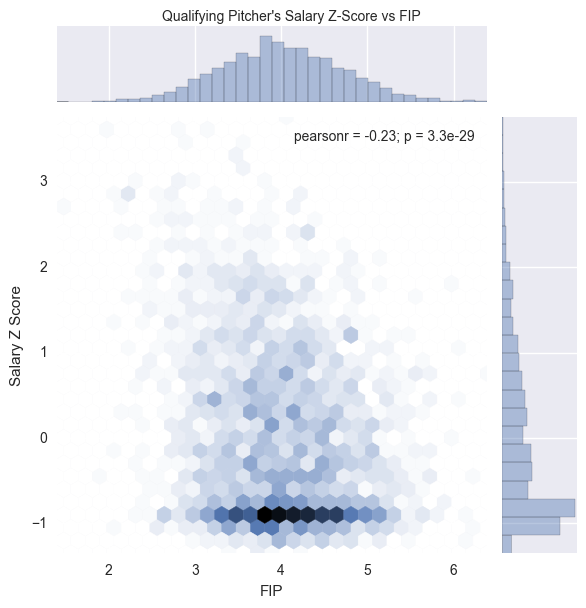

In [25]:
#Qualifying Pitcher's Salary as it relates to FIP
sns.jointplot(x="FIP", y="salary_Z",kind = "hex", data=player_FIP_graph_data).set_axis_labels('FIP','Salary Z Score')
plt.suptitle("Qualifying Pitcher's Salary Z-Score vs FIP",verticalalignment = 'bottom')

In this figure, I plotted a pitcher's salary Z score vs their FIP. We see that the Salary Z score has a strong postive skew. It seems that a large majority of pitchers get paid below the league average despite their performace. Which means that a team can get a pitcher at a low salary, without losing potential value of said pitcher. 

### Qualifying Pitcher's FIP, All-Stars compared to Non-All-Stars

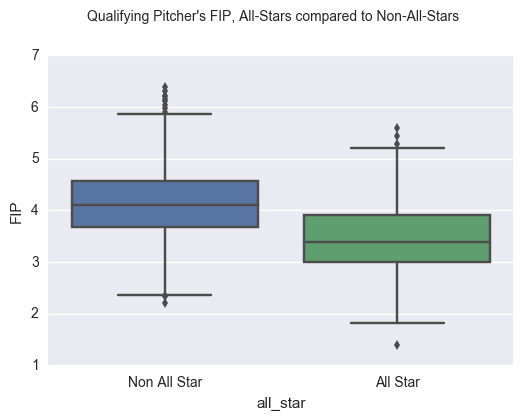

In [26]:
#qualifying pitchers FIP box plot, allstars vs non allstars
sns.boxplot(x="all_star", y="FIP", data=player_FIP_graph_data)
plt.suptitle("Qualifying Pitcher's FIP, All-Stars compared to Non-All-Stars",verticalalignment = 'bottom')

In this graph, I compared the difference in FIP for an All Star and a Non-All Star. The box plot here shows that All Stars have on average a lower FIP than Non-All stars. All Stars are selected as the best players in the league, so it makes sense that the FIP is lower for non all stars. Below I will describe this data to be used later. 

In [27]:
allstar_vs_non = player_FIP_graph_data[['FIP','all_star']].reset_index()
allstar_vs_non = allstar_vs_non.set_index(['all_star'])['FIP']
allstar_only = pd.DataFrame()
notallstar_only = pd.DataFrame()
allstar_only['FIP'] = allstar_vs_non.loc['All Star']
notallstar_only['FIP'] = allstar_vs_non.loc['Non All Star']
print "All Star Statistics:\n", allstar_only['FIP'].describe()
print "\nNon All Star Statistics:\n",notallstar_only['FIP'].describe()

All Star Statistics:
count    423.000000
mean       3.443993
std        0.656671
min        1.394791
25%        2.999718
50%        3.395172
75%        3.902555
max        5.592952
Name: FIP, dtype: float64

Non All Star Statistics:
count    1990.000000
mean        4.119017
std         0.650673
min         2.211648
25%         3.678890
50%         4.094826
75%         4.563086
max         6.390151
Name: FIP, dtype: float64


### Team ERA vs FIP

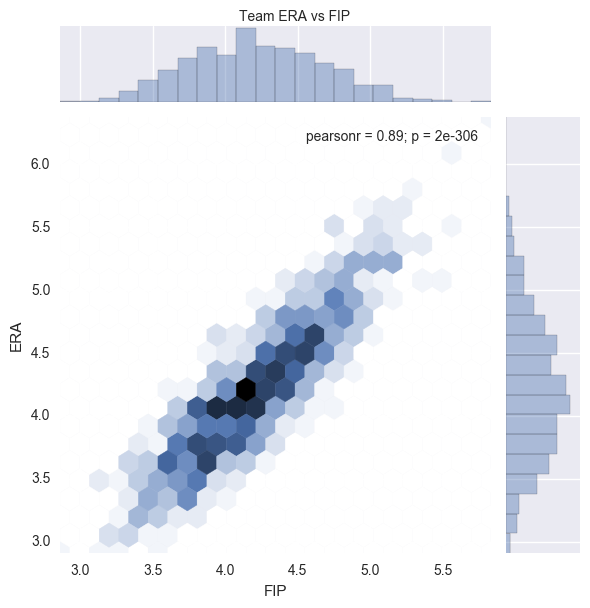

In [28]:
## Team ERA related to FIP
sns.jointplot(x="FIP", y="ERA",kind ="hex", data=team_FIP_graph_data)
plt.suptitle("Team ERA vs FIP",verticalalignment = 'bottom')

In this figure I compared team ERA as a function of team FIP. For this data there is a stronger correlation between FIP and ERA as the Pearson's R is 0.89 and closer to 1 than the Pearson's R for starting pitchers. But even with this large sample size, the data isn't perfectly correlated. Note the near normal distributions for both ERA and FIP.

### Team Salary Z Score vs FIP

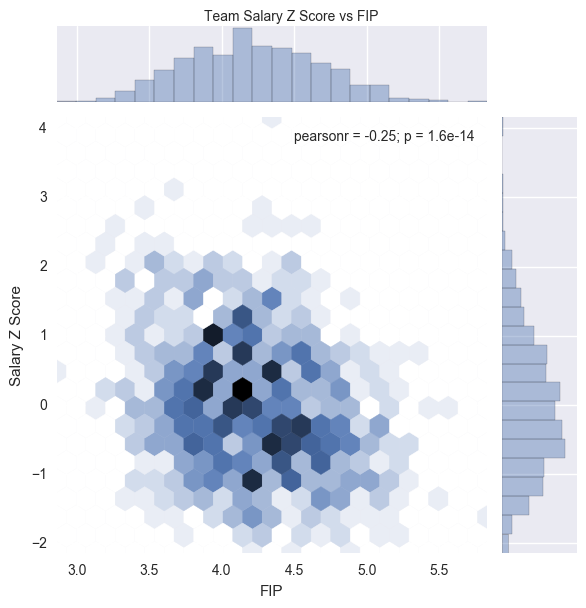

In [29]:
#Team Salary as it relates to team FIP
sns.jointplot(x="FIP", y="salary_Z",kind = "hex",data=team_FIP_graph_data).set_axis_labels('FIP','Salary Z Score')
plt.suptitle("Team Salary Z Score vs FIP",verticalalignment = 'bottom')

For this figure I plotted Salary Z Score of the team vs the FIP. This data correlates better than the salary data on the individual level, howeve is far from correlating perfectly. This shows an incorrect evaluation of a players worth by teams, if FIP is the only factor being taken into account. 

### Team Wins vs FIP

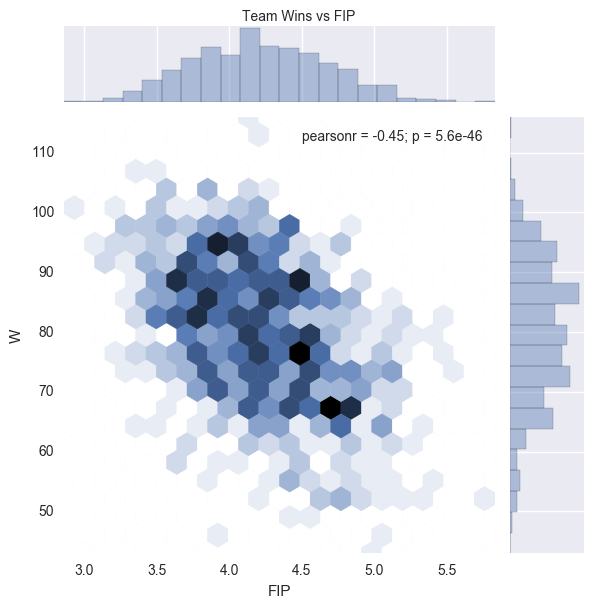

In [30]:
#Team Wins as they relate to FIP
sns.jointplot(x='FIP',y='W',kind = 'hex', data= team_FIP_graph_data)
plt.suptitle("Team Wins vs FIP",verticalalignment = 'bottom')

For this figure, the number of team wins is plotted vs the FIP of the team. Note the -0.45 Pearson's R, which shows a correlation between lower FIP resulting in higher wins for the team. However, there are other factors that may result in wins for the team, including offensive contribution. We can see though, that FIP may contribute some degree to team wins. 

### Team's FIP compared between Playoff Teams and Non Playoff Teams

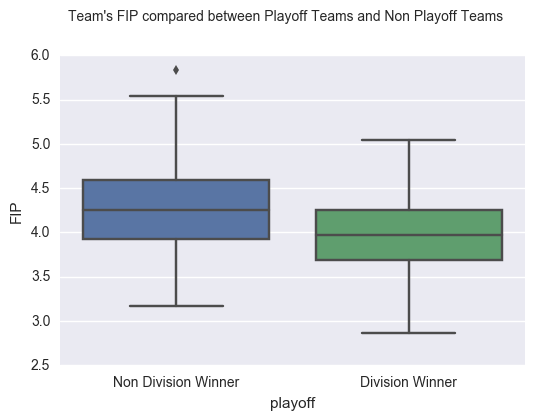

In [31]:
#qualifying pitchers FIP box plot, allstars vs non allstars
sns.boxplot(x="playoff", y="FIP", data=team_FIP_graph_data)
plt.suptitle("Team's FIP compared between Playoff Teams and Non Playoff Teams",verticalalignment = 'bottom')

For this figure I compared the difference between Division Winners and Non Division Winners. As might be expected, the Division Winners show a lower average FIP when compared to Non Division Winners. This indicates that better FIP scores are indication of a Division Winner. Below I will describe this data to be used later. 

In [32]:
division_vs_non =team_FIP_graph_data[['FIP','playoff']].reset_index()
division_vs_non = division_vs_non.set_index(['playoff'])['FIP']
division_only = pd.DataFrame()
notdivision_only = pd.DataFrame()
division_only['FIP'] = division_vs_non.loc['Division Winner']
notdivision_only['FIP'] = division_vs_non.loc['Non Division Winner']
print "Division Winner Statistics:\n", division_only['FIP'].describe()
print "\nNon Division Winner Statistics:\n",notdivision_only['FIP'].describe()

Division Winner Statistics:
count    168.000000
mean       3.978514
std        0.395634
min        2.859935
25%        3.685260
50%        3.976943
75%        4.254561
max        5.040063
Name: FIP, dtype: float64

Non Division Winner Statistics:
count    720.000000
mean       4.267588
std        0.454409
min        3.173577
25%        3.925690
50%        4.252517
75%        4.587279
max        5.831647
Name: FIP, dtype: float64


## Handling Missing Data
By choosing to only look at data from 1985 and after, I avoided dealing with missing salary data. Additionally, when handling All-Star data it was important to use the all-star table, as the Awards table stopped displaying All Star data in the late 80's which resulted in hundreds of potential missing data. For the all-star data, only players that made the team are in the actual table, resulting in 1990 missing values. I then changed these missing values to "Non-All Star" as they did not make the team. Similary for Cy Young data (2355 missing values) and MVP data (2410 missing values), even though the data was not used for this study I made sure to change the null data to False, to represent not being an MVP or Cy Young Award recipient. It was important to handle each column one at a time to find all of the null values, as changing all nulls in the table could lead to confusing data. For plotting purposes I made sure to change the data to list the exact string I wanted to use for the box and whisker plot to allow for easy readability. A crucial aspect of merging data here from multiple sources is to match up the indexes used. For most of the data I matched by yearID and playerID, for team data, yearID and teamID. 

# Conclusions

For the data here, we see that FIP is most closely correlated with ERA, with a Pearson's R of 0.78 and 0.89 for players and teams respectively. This fact tells me that both are probably equally reliable at determining a pitcher's value/team pitching value. We may see a lower correlation with a full calculation of pitcher WAR as there are more factors that influence the value. FIP and Wins are second most correlated, with a Pearson's R of -0.41 and -0.45 for players and teams respectively. The lower the FIP score in general means more wins. There are clearly lurking variables, here. A lurking varaible here is the number of runs scored by the pitcher's team. If a pitcher pitches a complete game (all 9 innings) and gives up 1 homerun, he would have a very low FIP, but if his team doesn't score a run, he loses the game. The least correlated statistics here are FIP and Salary, with a Pearson's R of -0.23 and -0.25 repectively. Salary data for Qualifying Starting Pitchers shows that generally the lower the FIP the higher the salary. However, lurking variables such as rookie contracts and the higher valuation of starting pitchings in general, can explain this divergent from what is expected. The salary data here is very strongly positively skewed, which makes sense as alot of players make rookie contracts intially. The team data, however shows a trend that is closer to what was expected, with lower FIP scores generally meaning higher salaries, this distribution is more normal than the individual salary distribution.

For this data there were certain limitations in calculating the exact value of a pitcher as determined by most of the baseball statistic community. Pitcher WAR is just one part FIP, with other parts coming from data that is not available in this data set, which might explain the decrease correlation in Salary and maybe also Wins. One more piece of information that might be useful, would be whether or not the player is still in their rookie contract, which would be another factor to explain why they are performing will with a lower salary. 


## Hypothesis Testing:
Two other areas I looked at was the difference in FIP between all-stars and non-allstars and division winner teams and division winner teams. On the individual level there is a clear decrease in FIP for All Stars as compared to Non All Stars, while for teams, there there is a clear decrease in FIP for division winners. Setting the Null Hypothesis here as follows:
> ** All Star FIP**

> **$H_0$**: The FIP of All Stars is not significantly smaller than that of Non All Stars, $\mu_A - \mu_N$ >= 0
>**$H_A$**: $\mu_A - \mu_N$ < 0, $\alpha <= 0.05$

> ** Division Winner FIP**

> **$H_0$**: The FIP of Division Winners is not significantly smaller than that of Non Division Winners. $\mu_D - \mu_N$ >=0 
> **$H_A$**: $\mu_D - \mu_N$ < 0, $\alpha <= 0.05$

Where:

$\mu_A$ = average FIP for All Stars

$\mu_N$ = average FIP for Non Allstars

$\mu_D$ = average FIP for team Division Winners

$\mu_N$ = average FIP for non-team divison Winners

Using Two Samples in each case we will need to perform a t Test. 

In [33]:
from scipy.stats import ttest_ind
#import t test script
t_allstar,p_allstar= ttest_ind(allstar_only['FIP'], notallstar_only['FIP'])
t_division, p_division = ttest_ind(division_only['FIP'], notdivision_only['FIP'])

print 'All Star FIP t Test Results:\nt statistic = ',t_allstar,'\np value = ',p_allstar, '\n'
print 'Division FIP t Test Results:\nt statistic = ',t_division,'\np value = ',p_division

All Star FIP t Test Results:
t statistic =  -19.3451165974 
p value =  1.26929717212e-77 

Division FIP t Test Results:
t statistic =  -7.59998708868 
p value =  7.53390265867e-14


As shown in the result of the t test performed here, the null hypothesis was rejected in both FIP cases for All Star vs Non All Star case and the Division Winner vs Non Division Winner Case. The p values for both tests are incrediably small, which means that the probability that is variation is due to sampling error is very small. This shows a strong correlation between having a lower FIP resulting in making the All Star team or Winning your division (at the team level). There is a small chance of Type I error, which would be mean that I rejected a true Null Hypothesis, however the p Value listed here, which needs to be less than 0.05 indicates strongly that this Type I error is unlikely. 

## Future Studies

There are several layers here that would be interesting to study. The obvious next step would be to compare WAR and value on the hitting side, then following that the relief pitcher side. Further dives into the salary side of all of these is incrediably important, as making sure you are not over paying as an owner and not being under paid as a player is worth investigating.